In [14]:
import pylab as pl
import sys
sys.path.append("../")

import os
import datetime
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scorecardpipeline import *


logger = init_setting(logger=True)

In [5]:
data = load_pickle("model_dataset.pickle")
data = data.with_columns(
    (pl.col("FPD") > 7).cast(pl.Int8).alias("target"),
    pl.col("申请时间").str.to_datetime(),
).filter(
    (pl.col("FPD") > 7) | (pl.col("FPD") == 0),
).select(
    ~cs.by_name('订单编号','客户编号','授信资方','放款时间','FPD','FSPD','FSTPD','DPD'),
)
data.head(2)

申请时间,lhfv3_v1,lhfv3_v3,lhfv1_highirr_v6,lhfv1_lowirr_v6,lhfv1_tongyong_v6,lhfv1_highirr_v7,lhfv1_lowirr_v7,lhfv1_tongyong_v7,圈团2风险等级V1,疑似准入风险V1,疑似被电诈V2,疑似被电诈V3,圈团1迭代浓度分V2,圈团3浓度分V1,疑似准入风险V2,1周内申请人逾期次数,1周内申请人逾期平台数,1个月内申请人逾期次数,1个月内申请人逾期平台数,3个月内申请人逾期次数,3个月内申请人逾期平台数,6个月内申请人逾期次数,6个月内申请人逾期平台数,12个月内申请人逾期次数,12个月内申请人逾期平台数,一年以前申请人逾期次数,一年以前申请人逾期平台数,1周内申请人逾期银行次数,1周内申请人逾期银行平台数,1个月内申请人逾期银行次数,1个月内申请人逾期银行平台数,3个月内申请人逾期银行次数,3个月内申请人逾期银行平台数,6个月内申请人逾期银行次数,6个月内申请人逾期银行平台数,12个月内申请人逾期银行次数,…,720天总申请夜晚平台数,180天银行申请白天平台数,360天银行申请白天平台数,720天银行申请白天平台数,180天银行申请夜晚平台数,360天银行申请夜晚平台数,720天银行申请夜晚平台数,7天相对过去180天新增总平台数,7天相对过去360天新增总平台数,7天相对过去720天新增总平台数,15天相对过去180天新增总平台数,15天相对过去360天新增总平台数,15天相对过去720天新增总平台数,30天相对过去180天新增总平台数,30天相对过去360天新增总平台数,30天相对过去720天新增总平台数,7天相对过去180天新增银行平台数,7天相对过去360天新增银行平台数,7天相对过去720天新增银行平台数,15天相对过去180天新增银行平台数,15天相对过去360天新增银行平台数,15天相对过去720天新增银行平台数,30天相对过去180天新增银行平台数,30天相对过去360天新增银行平台数,30天相对过去720天新增银行平台数,最早一次查询距今的天数,最近一次查询距今的天数,最早一次在银行机构距今的天数,最近一次在银行机构距今的天数,最早一次在非银机构距今的天数,最近一次在非银机构距今的天数,多头申请通用分,长周期多头共债子分,短周期多头共债子分,非银行多头共债子分,银行多头共债子分,target
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8
2023-09-28 15:35:48,734.0,728.0,14.0,13.0,13.0,30.0,27.0,20.0,null,null,null,NaN,37.0,25.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1206.0,1.0,1206.0,50.0,905.0,1.0,56.0,51.0,66.0,52.0,54.0,0
2023-09-28 18:01:56,713.0,655.0,34.0,40.0,34.0,44.0,49.0,41.0,null,null,null,NaN,43.0,15.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.0,-8.0,-12.0,-3.0,-8.0,-12.0,-3.0,-8.0,-12.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,1129.0,51.0,996.0,432.0,1129.0,51.0,41.0,41.0,44.0,41.0,46.0,0


In [25]:
train = data.filter(pl.col("申请时间") > datetime.datetime(year=2023, month=9, day=1))
train, test = train_test_split(train, test_size=0.2, stratify=train["target"])
oot = data.filter(pl.col("申请时间") <= datetime.datetime(year=2023, month=9, day=1))

In [26]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,21 hours 13 mins
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,5 months and 29 days
H2O_cluster_name:,H2O_from_python_lubberit_d840sg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.739 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [42]:
select = FeatureSelection(target="target", engine="scorecardpy", identical=0.95, empty=0.95, iv=0.02, corr=0.9, remove="申请时间")
select.fit(train.to_pandas())

train_select = h2o.H2OFrame(select.transform(train).to_pandas())
test_select = h2o.H2OFrame(select.transform(test).to_pandas())
oot_select = h2o.H2OFrame(select.transform(oot).to_pandas())

[INFO] filtering variables ...
Variable filtering on 95778 rows and 348 columns in 00:00:30 
186 variables are removed
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [43]:
y = "target"
x = list(train_select.drop(y).columns)

# For binary classification, response should be a factor
train_select[y] = train_select[y].asfactor()
test_select[y] = test_select[y].asfactor()
oot_select[y] = oot_select[y].asfactor()

In [114]:
# Run AutoML for 30 seconds
aml = H2OAutoML(nfolds=5
                , max_runtime_secs=100
                # , balance_classes=True
                , stopping_metric="lift_top_group"
                , stopping_rounds=5
                # , project_name="scorecardpipeline"
                , include_algos=["XGBoost", "GBM", "DRF", "StackedEnsemble"]
                , sort_metric="logloss"
               )
aml.train(x=x, y=y, training_frame=train_select, validation_frame=test_select)

AutoML progress: |
22:44:26.323: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_10_20240414_224426


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  2/2
# GBM base models (used / total)      1/1
# XGBoost base models (used / total)  1/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.014732754309517466
RMSE: 0.1213785578655368
LogLoss: 0.0722913786476122
AUC: 0.9692753119443059
AUCPR: 0.520746595774342
Gini: 0.9385506238886119
Null degrees of freedom: 10024
Residual degrees of freedom: 10022
Null deviance: 1649.8242864782364
Residual deviance: 1449.4421418846246
AIC: 1455.4421418846246

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07301502446418714
       0     1    Error    Rate
-----  ----  ---  -------  ---------------
0      9825  39   0.004    (39.0/9864.0)
1      92    69   0.5714   (92.0/161.0)
Total  9917  108  0.0131   (131.0/10025.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.073015     0.513011  61
max f2                       0.0535493    0.582915  108
max f0point5                 0.076222     0.586592  57
max accuracy                 0.076222     0.987132  57
max precision                0.187031     1         0
max recall                   0.0254029    1         299
max specificity              0.187031     1         0
max absolute_mcc             0.073015     0.517054  61
max min_per_class_accuracy   0.0418811    0.913043  162
max mean_per_class_accuracy  0.0418811    0.914399  162
max tns                      0.187031     9864      0
max fns                      0.187031     160       0
max fps                      0.0128539    9864      399
max tps                      0.0254029    161       299
max tnr                      0.187031     1         0
max fnr                      0.187031     0.993789  0
max fpr                      0.0128539    1         399
max tpr                      0.0254029    1         299

Gains/Lift Table: Avg response rate:  1.61 %, avg score:  2.98 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100748                   0.0744059          40.6894    40.6894            0.653465         0.0974563  0.653465                    0.0974563           0.409938        0.409938                   3968.94   3968.94            0.40639
2        0.0200499                   0.0616542          11.8307    26.3319            0.19             0.0665947  0.422886                    0.0821023           0.118012        0.52795                    1083.07   2533.19            0.51619
3        0.0300249                   0.0551544          13.6988    22.1348            0.22             0.0582598  0.355482                    0.0741812           0.136646        0.664596                   1269.88   2113.48            0.644929
4        0.04                        0.0515555          8.09472    18.6335            0.13             0.0534135  0.299252                    0.0690022           0.0807453       0.745342                   709.47

In [115]:
# Print Leaderboard (ranked by xval metrics)
aml.leaderboard

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_10_20240414_224426,0.0792961,0.614719,0.026182,0.455496,0.123967,0.0153678
GBM_2_AutoML_10_20240414_224426,0.080128,0.606528,0.0246042,0.467163,0.124128,0.0154077
GBM_3_AutoML_10_20240414_224426,0.0803648,0.601025,0.022218,0.458346,0.124273,0.0154437
GBM_4_AutoML_10_20240414_224426,0.0804008,0.579075,0.0219133,0.473836,0.124196,0.0154246
StackedEnsemble_BestOfFamily_2_AutoML_10_20240414_224426,0.0804754,0.560877,0.0212636,0.47342,0.12414,0.0154107
GBM_1_AutoML_10_20240414_224426,0.0804876,0.603757,0.0292934,0.470059,0.124148,0.0154126
XGBoost_1_AutoML_10_20240414_224426,0.12758,0.610387,0.0233224,0.455001,0.143265,0.0205249
DRF_1_AutoML_10_20240414_224426,0.206885,0.553359,0.0207998,0.474785,0.139758,0.0195323
XGBoost_2_AutoML_10_20240414_224426,0.45345,0.56302,0.0191009,0.469484,0.364877,0.133135


In [116]:
# (Optional) Evaluate performance on a test set
perf_test = aml.leader.model_performance(test_select)
perf_test.auc()

0.615829274501485

In [117]:
# (Optional) Evaluate performance on a test set
perf_oot = aml.leader.model_performance(oot_select)
perf_oot.auc()

0.5807054204660588

In [118]:
best_model = aml.get_best_model()
# best_model.explain(oot_select);

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


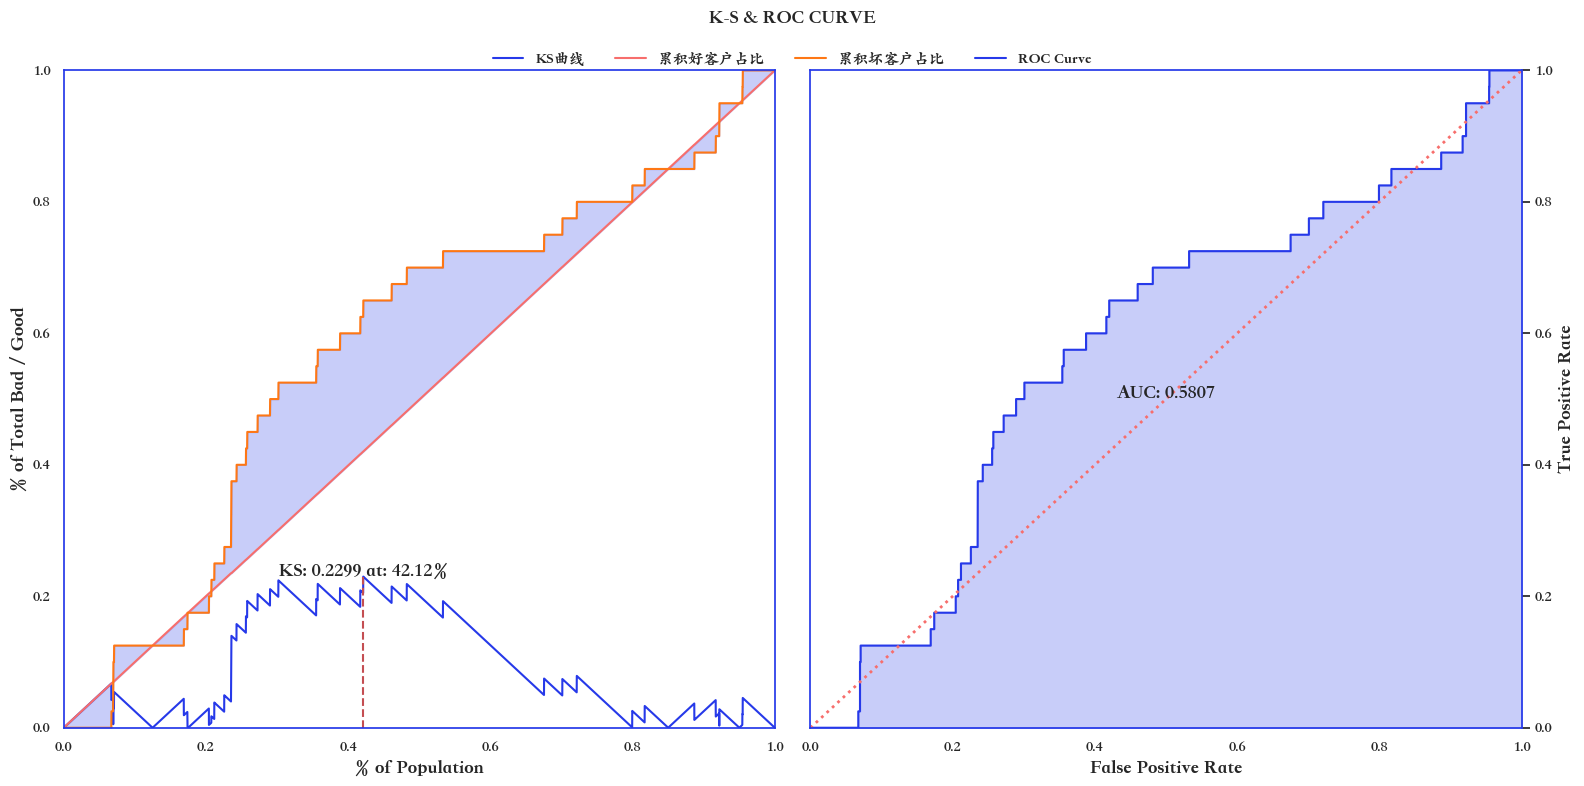

In [119]:
ks_plot(best_model.predict(oot_select).as_data_frame()["p1"], oot_select.as_data_frame()[y]);

In [131]:
best_model._estimator_type

In [127]:
feature_bin_stats(
    pd.DataFrame({"score": best_model.predict(test_select).as_data_frame()["p1"], "target": test_select.as_data_frame()[y]})
    , "score"
    , method="mdlp"
)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,坏账改善,累积LIFT值,累积坏账改善,累积好样本数,累积坏样本数,分档KS值
0,score,,"[负无穷 , 0.0184)",1968.0000,0.0822,1959.0000,0.0831,9.0000,0.0240,0.0046,1.2421,0.0734,0.2404,0.2920,-0.0634,1.0000,0.0000,23570.0000,375.0000,0.0000
1,score,,"[0.0184 , 0.0248)",6493.0000,0.2712,6426.0000,0.2726,67.0000,0.1787,0.0103,0.4226,0.0397,0.2404,0.6589,-0.1269,1.0634,0.7080,21611.0000,366.0000,0.0591
2,score,,"[0.0248 , 0.0266)",2200.0000,0.0919,2172.0000,0.0922,28.0000,0.0747,0.0127,0.2104,0.0037,0.2404,0.8127,-0.0190,1.2330,0.4264,15185.0000,299.0000,0.1531
3,score,,"[0.0266 , 0.0325)",6310.0000,0.2635,6213.0000,0.2636,97.0000,0.2587,0.0154,0.0189,0.0001,0.2404,0.9816,-0.0066,1.3026,0.3771,13013.0000,271.0000,0.1706
4,score,,"[0.0325 , 0.0579)",6466.0000,0.2700,6322.0000,0.2682,144.0000,0.3840,0.0223,-0.3588,0.0415,0.2404,1.4220,0.1561,1.5931,0.2437,6800.0000,174.0000,0.1755
5,score,,"[0.0579 , 正无穷)",508.0000,0.0212,478.0000,0.0203,30.0000,0.0800,0.0591,-1.3724,0.0820,0.2404,3.7709,0.0601,3.7709,0.0601,478.0000,30.0000,0.0597
6,score,,缺失值,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [ ]:
best_model.predict(test_select).as_data_frame()["p1"]

In [188]:
score_transform = StandardScoreTransformer(score0=500, pdo=50, bad_rate=train[y].mean(), greater_is_better=False)
# score_transform = BoxCoxScoreTransformer()

In [189]:
score_transform.fit(best_model.predict(test_select).as_data_frame()[["p0"]])

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


StandardScoreTransformer(bad_rate=0.015661216563302636, greater_is_better=False,
                         pdo=50, score0=500)

In [190]:
feature_bin_stats(
    pd.DataFrame({"score": score_transform.transform(best_model.predict(test_select).as_data_frame()[["p0"]])["p0"], "target": test_select.as_data_frame()[y]})
    , "score"
    , method="mdlp"
)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,坏账改善,累积LIFT值,累积坏账改善,累积好样本数,累积坏样本数,分档KS值
0,score,,"[负无穷 , 624.9255)",508.0000,0.0212,478.0000,0.0203,30.0000,0.0800,0.0591,-1.3724,0.0820,0.2404,3.7709,0.0601,3.7709,0.0601,478.0000,30.0000,0.0597
1,score,,"[624.9255 , 668.492)",6466.0000,0.2700,6322.0000,0.2682,144.0000,0.3840,0.0223,-0.3588,0.0415,0.2404,1.4220,0.1561,1.5931,0.2437,6800.0000,174.0000,0.1755
2,score,,"[668.492 , 683.3262)",6310.0000,0.2635,6213.0000,0.2636,97.0000,0.2587,0.0154,0.0189,0.0001,0.2404,0.9816,-0.0066,1.3026,0.3771,13013.0000,271.0000,0.1706
3,score,,"[683.3262 , 688.4017)",2200.0000,0.0919,2172.0000,0.0922,28.0000,0.0747,0.0127,0.2104,0.0037,0.2404,0.8127,-0.0190,1.2330,0.4264,15185.0000,299.0000,0.1531
4,score,,"[688.4017 , 710.2586)",6493.0000,0.2712,6426.0000,0.2726,67.0000,0.1787,0.0103,0.4226,0.0397,0.2404,0.6589,-0.1269,1.0634,0.7080,21611.0000,366.0000,0.0591
5,score,,"[710.2586 , 正无穷)",1968.0000,0.0822,1959.0000,0.0831,9.0000,0.0240,0.0046,1.2421,0.0734,0.2404,0.2920,-0.0634,1.0000,0.0000,23570.0000,375.0000,0.0000
6,score,,缺失值,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [187]:
score_transform.transform(best_model.predict(test_select).as_data_frame()[["p1"]]).describe()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


,p1
count,23945.0000
mean,304.6197
std,1.6628
min,300.0038
25%,303.4987
50%,304.6367
75%,305.7444
max,309.0096


In [157]:
from abc import abstractmethod
import numpy as np
from pandas import DataFrame
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted


class BaseScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, down_lmt=300, up_lmt=1000, greater_is_better=True, cutoff=None):
        self.down_lmt = down_lmt
        self.up_lmt = up_lmt
        self.greater_is_better = greater_is_better
        self.cutoff = cutoff

    @abstractmethod
    def predict(self, x):
        pass


class StandardScoreTransformer(BaseScoreTransformer):
    """Stretch the predicted probability to a normal distributed score."""
    def __init__(self, score0=660, pdo=75, bad_rate=0.15, down_lmt=300, up_lmt=1000, greater_is_better=True, cutoff=None):
        super().__init__(down_lmt=down_lmt, up_lmt=up_lmt, greater_is_better=greater_is_better, cutoff=cutoff)
        self.score0 = score0
        self.pdo = pdo
        self.bad_rate = bad_rate

    def fit(self, X, y=None, **fit_params):
        self._validate_data(X, reset=True, accept_sparse=False, dtype="numeric", copy=False, force_all_finite=True)

        score0, down_lmt, up_lmt = self.score0, self.down_lmt, self.up_lmt
        if not down_lmt < score0 < up_lmt:
            raise ValueError("score0 should be greater than {} and less than {}!".format(down_lmt, up_lmt))
        
        bad_rate = self.bad_rate
        if not 0.0 < bad_rate < 1.0:
            raise ValueError("bad rate should be greater than e and less than 1!")
        
        odds = bad_rate / (1. - bad_rate)
        if self.greater_is_better:
            B = self.pdo / np.log(2.0)
        else:
            B = -self.pdo / np.log(2.0)

        A = score0 + B + np.log(odds)

        self.A_ = A
        self.B_ = B
        self.odds_ = odds
        return self
    
    def _transform(self, X):
        check_is_fitted(self, ["A_", "B_"])
        Xt = self._validate_data(X, reset=False, accept_sparse=False, dtype="numeric", copy=True, force_all_finite=True)
        # if not np.all((0 <= Xt) & (Xt <= 1)):
        #     raise ValueError ("Input should be probabilities between 0 and 1.")
        A, B = self.A_, self.B_
        down_lmt, up_lmt = self.down_lmt, self.up_lmt
        points =A - B * np.log(Xt / (1.0 - Xt))
        points = np.clip(points, down_lmt, up_lmt)
        return points

    def transform(self, X):
        data = self._transform(X)
        if isinstance(X, DataFrame):
            columns = X.columns
            index = X.index
            return DataFrame(data=data, columns=columns, index=index)
        return data
    
    def predict(self, X):
        scores = np.ravel(self._transform(X))
        if self.cutoff is None:
            cutoff = self._transform([[0.5]])[0][0]
        elif not self.down_lmt < self.cutoff < self.up_lmt:
            raise ValueError("Cutoff point should be within down_lmt and up_lmt!")
        else:
            cutoff = self.cutoff
        
        if self.greater_is_better:
            return (scores < cutoff).astype(np.int)
        else:
            return (scores > cutoff).astype (np.int)
        
    def _inverse_transform(self, X):
        check_is_fitted(self, ["A_", "B_"])
        Xt = check_array(X, accept_sparse=False, dtype="numeric", copy=True, force_all_finite=True)
        down_lmt, up_lmt = self.down_lmt, self.up_lmt
        if not np.all(np.logical_and((down_lmt <= Xt), (Xt <= up_lmt))):
            raise ValueError("Input should be points between {} and {}".format(down_lmt, up_lmt))
        A, B = self.A_, self.B_
        probs = 1.0 - 1.0 / (np.exp((A - Xt) / B) + 1.0)
        return probs
    
    def inverse_transform(self, X):
        data = self. inverse_transform(X)
        if isinstance(X, DataFrame):
            columns = X.columns
            index = X.index
            return DataFrame(data=data, columns=columns, index=index)
        return data
    
    def _more_tags(self):
        return {
            "X_types": ["2darray"],
            "allow_nan": False,
        }


class NPRoundStandardScoreTransformer(StandardScoreTransformer):
    """Stretch the predict probability to a normal distributed score."""
    def __init__(self, score0=660,pdo=75, bad_rate=0.15, down_lmt=300, up_lmt=1000, round_decimals=0, greater_is_better=True, cutoff=None):
        self.round_decimals = round_decimals
        super(NPRoundStandardScoreTransformer, self).__init__(score0=score0, pdo=pdo, bad_rate=bad_rate, down_lmt=down_lmt, up_lmt=up_lmt,
                                                              greater_is_better=greater_is_better, cutoff=cutoff)

    def _transform(self, X):
        points = super()._transform(X)
        decimals = self.round_decimals
        points = np.round(points, decimals=decimals)
        return points


class RoundStandardScoreTransformer(StandardScoreTransformer):
    """Stretch the predicted probability to a normal distributed score."""
    def __init__(self, score0=660, pdo=75, bad_rate=0.15, down_lmt=300, up_lmt=1000, round_decimals=0, greater_is_better=True, cutoff=None):
        self.round_decimals = round_decimals
        super(RoundStandardScoreTransformer, self).__init__(score0=score0, pdo=pdo, bad_rate=bad_rate, down_lmt=down_lmt, up_lmt=up_lmt,
                                                            greater_is_better=greater_is_better, cutoff=cutoff)
    def _transform(self, X):
        points  = super()._transform(X)
        decimals = self.round_decimals
        points = np.array([[round(x[0], decimals)] for x in points])
        return points


class BoxCoxScoreTransformer(BaseScoreTransformer):
    def __init__(self, down_lmt=300, up_lmt=1000, greater_is_better=True, cutoff=None):
        super(BoxCoxScoreTransformer, self).__init__(down_lmt=down_lmt, up_lmt=up_lmt, greater_is_better=greater_is_better, cutoff=cutoff)
    
    def _box_cox_optimize(self, x):
        """Find and return optimal lambda parameter of the Box-Cox transform by MLE, for observed data x.

        We here use scipy builtins which uses the brent optimizer.
        """
        # the computation of Lambda is influenced by NaNs so we need to get rid of them
        _, lmbda = stats.boxcox(x, lmbda=None)
        return lmbda

    def fit(self, X, y=None, **fit_params):
        X = check_array(X, accept_sparse=False, dtype="numeric", copy=True, force_all_finite=True)
        if np.min(X) <= 0 or np.max(X) >= 1:
            raise ValueError("The Box-Cox score transformation can only be applied to strictly positive probabilities")
        if self.greater_is_better:
            self.lambdas_ = np.array([self._box_cox_optimize(1.0 - col) for col in X.T])
        else:
            self.lambdas_ = np.array([self._box_cox_optimize(col) for col in X.T])
        for i, lmbda in enumerate(self.lambdas_) :
            X[:, i] = stats.boxcox(X[:, i], lmbda)
        self.scaler_ = MinMaxScaler(feature_range=(self.down_lmt, self.up_lmt)).fit(X)
        return self

    def _transform(self, X):
        check_is_fitted(self, ["lambdas_", "scaler_"])
        X = check_array(X, accept_sparse=False, dtype="numeric", copy=True, force_all_finite=True)
        if np.min(X) < 0 or np.max(X) > 1:
            raise ValueError("The Box-Cox score transformation can only be applied to strictly positive probabilities")
        if self.greater_is_better:
            X = 1.0 - X
        for i, lmbda in enumerate(self.lambdas_):
            X[:, i]= stats.boxcox(X[:, i], lmbda)
        return self.scaler_.transform(X)

    def transform(self, X):
        data = self._transform(X)
        if isinstance(X, DataFrame):
            columns = X.columns
            index = X.index
            return DataFrame(data=data, index=index, columns=columns)
        return data
    
    def predict(self, X):
        scores = np.ravel(self._transform(X))
        if self.cutoff is None:
            lmbda = self.lambdas_[0]
            if lmbda != 0:
                p = (0.5 ** lmbda - 1) / lmbda
            else:
                p = np.log(0.5)
            scaler = self.scaler_
            p *= scaler.scale_
            p += scaler.min_
            if scaler.clip:
                if p < scaler.feature_range[0]:
                    p = scaler.feature_range[0]
                elif p > scaler.feature_range[1]:
                    p = scaler.feature_range[1]
            cutoff = p
        elif not self.down_lmt < self.cutoff < self.up_lmt:
            raise ValueError("Cutoff point should be within 'down_lmt' and 'up_lmt'!")
        else:
            cutoff = self.cutoff
        if self.greater_is_better:
            return (scores < cutoff).astype(np.int)
        else:
            return (scores > cutoff).astype(np.int)

    def _inverse_transform(self, X):
        check_is_fitted(self, ["lambdas_", "scaler_"])
        X = check_array(X, accept_sparse=False, dtype="numeric", copy=True, force_all_finite=True)
        if np.min(X) < self.down_lmt or np.max(X) > self.up_lmt:
            raise ValueError("The Box-Cox score inverse transformation can only be applied to strictly bounded scores")
        X_inv = self.scaler_.inverse_transform(X)
        for i, lmbda in enumerate(self.lambdas ):
            X_inv[:, i] = self._box_cox_inverse_tranform(X_inv[:, i], lmbda)
        return X_inv

    def inverse_transform(self, X):
        data = self._inverse_transform(X)
        if isinstance(X, DataFrame):
            columns = X.columns
            index = X.index
            return DataFrame(data=data, index=index, columns=columns)
        return data

    def _box_cox_inverse_tranform(self, x, lmbda):
        """Return inverse-transformed input x following Box-Cox inverse transform with parameter lambda"""
        if lmbda == 0:
            x_inv = np.exp(x)
        else:
            x_inv = (x * lmbda + 1) ** (1 / lmbda)

        return x_inv